In [1]:
import numpy as np 
import pandas as pd 
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch import nn
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
print(train_data[:5])

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [5]:
all_features = pd.concat((train_data.iloc[:,1:],test_data.iloc[:,1:]))

In [6]:
print(all_features.shape)

(2919, 80)


In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean())/x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features = all_features.astype(np.float32)
print(all_features.shape)

(2919, 331)


In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [10]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
num_hiddens = int((1+in_features)/2)
dropout = 0
print(in_features,num_hiddens)

def init_weight(m):
    if m.type == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

def get_net():
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features,num_hiddens),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(num_hiddens,1)
    )
    net.apply(init_weight)
    return net

331 166


In [11]:
def log_rmse(net,features,labels):
    clipped_preds = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [12]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_set = TensorDataset(train_features,train_labels)
    train_iter = DataLoader(train_set,batch_size,shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [13]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train,y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat([X_train,X_part],0)
            y_train = torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_valid

In [14]:
def plot(train_ls,valid_ls,num_epochs):
    plt.plot(range(1,num_epochs+1),train_ls,label='train')
    if valid_ls is not None:
        plt.plot(range(1,num_epochs+1),valid_ls,label='valid')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('rmse')
    plt.xticks(np.arange(0,100,20))
    plt.grid(True)
    plt.yscale('log')
    plt.show()

In [15]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_rmse,valid_rmse = [],[]
    output = []
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        for rmse_set,rmse in zip([train_rmse,valid_rmse],[train_ls,valid_ls]):
            rmse_set.append(rmse)
        print(f'折{i+1},训练log rmse：{float(train_ls[-1]):f}，验证log rmse:{float(valid_ls[-1]):f}')
    for rmse_set,i in zip([train_rmse,valid_rmse],[0,1]):
        rmse_set = zip(*rmse_set)
        output.append([sum(column)/len(column) for column in rmse_set]) 
    return output[0],output[1]

折1,训练log rmse：0.005586，验证log rmse:0.018012
折2,训练log rmse：0.005812，验证log rmse:0.027609
折3,训练log rmse：0.005475，验证log rmse:0.022077
折4,训练log rmse：0.017210，验证log rmse:0.020995
折5,训练log rmse：0.008525，验证log rmse:0.035414


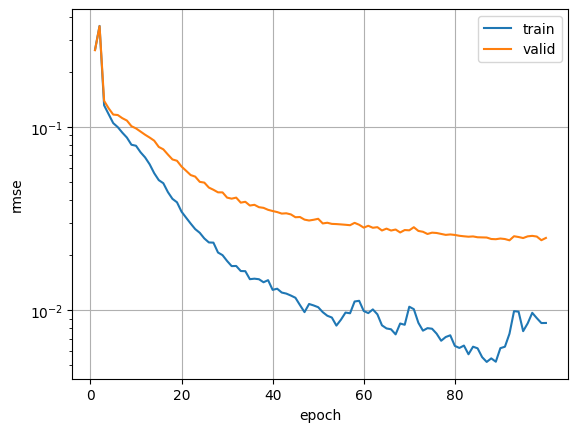

5-折验证：平均训练log rmse：0.008522，平均验证log rmse：0.024821


In [16]:
k,num_epochs,lr,weight_decay,batch_size = 5,100,0.4,0.5,64
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
plot(train_l,valid_l,num_epochs)
print(f'{k}-折验证：平均训练log rmse：{float(train_l[-1]):f}，平均验证log rmse：{float(valid_l[-1]):f}')

In [17]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    plot(train_ls,None,num_epochs)
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.csv',index=False)

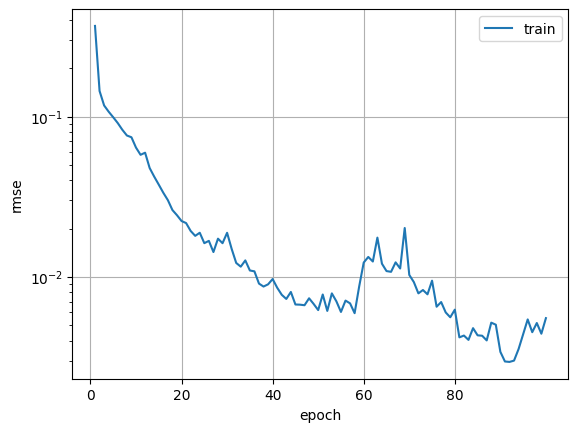

训练log rmse：0.005520


In [18]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)

In [19]:
# sub = pd.read_csv('submission.csv')
# print(sub)